# Reconhecimento de Emoções Faciais (FER) em Tempo Real

# 1- Contextualização

O Reconhecimento de Expressão Facial (FER) configura-se como uma disciplina fundamental no domínio da Inteligência Artificial (IA), integrando-se de maneira intrínseca à visão computacional e ao processamento de imagens. Seu propósito central reside na identificação e interpretação das expressões emocionais humanas, mediante análise de imagens faciais. Esta área visa habilitar sistemas computacionais a compreenderem e reagirem de maneira apropriada às nuances emocionais humanas, proporcionando uma ferramenta de relevância marcante em diversas aplicações práticas, como entretenimento (exemplificado em jogos), saúde mental, educação, publicidade, pesquisa de mercado e interação homem-máquina.

A decodificação de emoções a partir de expressões faciais representa, inquestionavelmente, um desafio complexo, dada a diversidade na manifestação de sentimentos entre diferentes indivíduos. Não obstante, avanços recentes em algoritmos de Aprendizado Profundo, notadamente em redes neurais convolucionais (CNNs), têm propiciado incrementos notáveis na precisão desta área.

# 2- Metodologia e objetivos

A metodologia adotada concentrou-se exclusivamente na base de dados FER2013 para treinamento e validação do modelo. A escolha desta base de dados se deu devido à sua abrangência e representatividade em termos de expressões emocionais.

O processo de treinamento do modelo incorporou a técnica de Transfer Learning, utilizando a FaceNet como modelo pré-treinado. Essa abordagem permitiu aproveitar os conhecimentos adquiridos pela FaceNet em tarefas relacionadas, acelerando o aprendizado do modelo específico para o Reconhecimento de Expressão Facial (FER).

A etapa de avaliação do modelo incluiu a submissão do sistema ao reconhecimento de expressões em tempo real. Esta fase envolveu a implementação do modelo em ambientes que replicam situações do mundo real, permitindo uma avaliação mais precisa da sua eficácia em cenários dinâmicos.

# 3- Inicializações globais

In [ ]:
import math
import numpy as np
import pandas as pd

import cv2
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers, models

from keras.utils import to_categorical

# Check GPU availability
print("GPU Available:", tf.test.is_gpu_available())

#Bibliotecas nessesarias não inclusas
!pip install scikit-plot
import scikitplot

#!pip install keras

!pip install kaggle

#Baixando "kaggle.json" nesseario para baixar a base de dados
!gdown --id 1cedMQxKyFmeSrHIvKrgeOBlBxcGBQDkC -O kaggle.json

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available: False
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1cedMQxKyFmeSrHIvKrgeOBlBxcGBQDkC
To: /content/kaggle.json
100% 72.0/72.0 [00:00<00:00, 354kB/s]


# 4- Carregando conjunto de dados FER-2013

Este código é um procedimento que configura o ambiente do Google Colab para usar a API do Kaggle.

O trecho de código para montar o Google Drive está comentado, o que significa que não será executado. Caso descomentado, seria usado para montar o Google Drive no ambiente do Colab.

E definido o caminho para o arquivo kaggle.json no Google Drive e o diretório .kaggle no ambiente do Colab.
Cria-se o diretório .kaggle se ele ainda não existir.
Copia o arquivo kaggle.json do Google Drive para o diretório .kaggle.
Altera as permissões do arquivo kaggle.json para garantir que apenas o proprietário tenha permissão de leitura e gravação.

Em resumo, esse código facilita a utilização da API do Kaggle no Google Colab, permitindo o acesso direto a conjuntos de dados e competições hospedados no Kaggle.

In [ ]:
#Procedimento para baixa direto kaggle
from google.colab import drive
from pathlib import Path
'''
# Montar o Google Drive
drive.mount('/content/drive')
'''

# Configura o ambiente Google Colab para uso do Kaggle
kaggle_json_path = '/content/kaggle.json'   # Caminho para o arquivo kaggle.json no Google Drive (manter padronizado!)

colab_kaggle_dir = Path('/root/.kaggle')                          # Caminho para o diretório .kaggle no Colab
colab_kaggle_dir.mkdir(parents=True, exist_ok=True)               # Criar o diretório .kaggle se não existir
!cp "{kaggle_json_path}" "{colab_kaggle_dir / 'kaggle.json'}"     # Copiar o arquivo kaggle.json do Google Drive para o Colab
!chmod 600 "{colab_kaggle_dir / 'kaggle.json'}"                   # Alterar as permissões do arquivo

O código abaixo utiliza a API do Kaggle para fazer o download e descompactar os arquivos associados ao conjunto de dados FER-2013 diretamente no ambiente do Google Colab. O conjunto de dados FER-2013 é frequentemente utilizado em tarefas de reconhecimento de expressões faciais.

In [ ]:
#Finalmente importa a base dados direto do kaggle
import kaggle
from zipfile import ZipFile

# Configurar a API Kaggle usando suas credenciais
kaggle.api.authenticate()

# Baixar o conjunto de dados FER-2013
kaggle.api.dataset_download_files('ashishpatel26/facial-expression-recognitionferchallenge', unzip=True)


Essa penultima parte da parte 4, é uma medida preventiva para lidar com imagens corrompidas que podem estar presentes nos conjuntos de dados. Isso é especialmente útil ao trabalhar com grandes conjuntos de dados, onde a presença de algumas imagens corrompidas pode causar problemas durante o treinamento de modelos ou a análise de dados. A função remove_corrupted_images identifica e exclui essas imagens corrompidas, garantindo a integridade dos dados para as tarefas subsequentes.

In [ ]:
#Tratando Arquivos corrompidos os removendo
import os
from PIL import Image

def remove_corrupted_images(directory):
  # Listar todos os arquivos no diretório
  image_files = []
  for root, dirs, files in os.walk(directory):
    for file in files:
      image_files.append(os.path.join(root, file))

  # Lista para armazenar os nomes dos arquivos corrompidos
  corrupted_images = []

  for image_file in image_files:
    try:
      # Tentar abrir a imagem
      with Image.open(image_file) as img:
        # Não precisa fazer nada se a imagem for aberta corretamente
        pass
    except Exception as e:
      # Se ocorrer um erro ao abrir a imagem, adicionar o caminho do arquivo à lista de imagens corrompidas
      corrupted_images.append(image_file)
      print(f"Erro ao abrir a imagem {image_file}: {e}")

  # Remover imagens corrompidas
  for corrupted_image in corrupted_images:
    os.remove(corrupted_image)
    print(f"Imagem corrompida removida: {corrupted_image}")

# Remover imagens corrompidas do diretório de treinamento
remove_corrupted_images('/content/train')

# Remover imagens corrompidas do diretório de teste
remove_corrupted_images('/content/test')


In [ ]:
#Testando se importou corretamente
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('fer2013'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

fer2013/fer2013/fer2013.csv
fer2013/fer2013/fer2013.bib
fer2013/fer2013/README


Para finalizar a parte de carregamento de dados, este código prepara geradores de dados para alimentar um modelo de aprendizado de máquina com imagens de treino e teste, realizando o pré-processamento necessário, como redimensionamento e normalização. Os geradores são configurados para lidar com imagens em tons de cinza e rótulos inteiros, e o número de classes é extraído do gerador de treino para fins de configuração do modelo.

In [ ]:
#Lendo
df = pd.read_csv('fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()
df.emotion.unique()
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
df.emotion.value_counts()

img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis = 0)

(35887, 3)


{0: 'anger',
 1: 'disgust',
 2: 'fear',
 3: 'happiness',
 4: 'sadness',
 5: 'surprise',
 6: 'neutral'}

# 5- Explorando o conjunto de dados

(35887, 48, 48, 3)


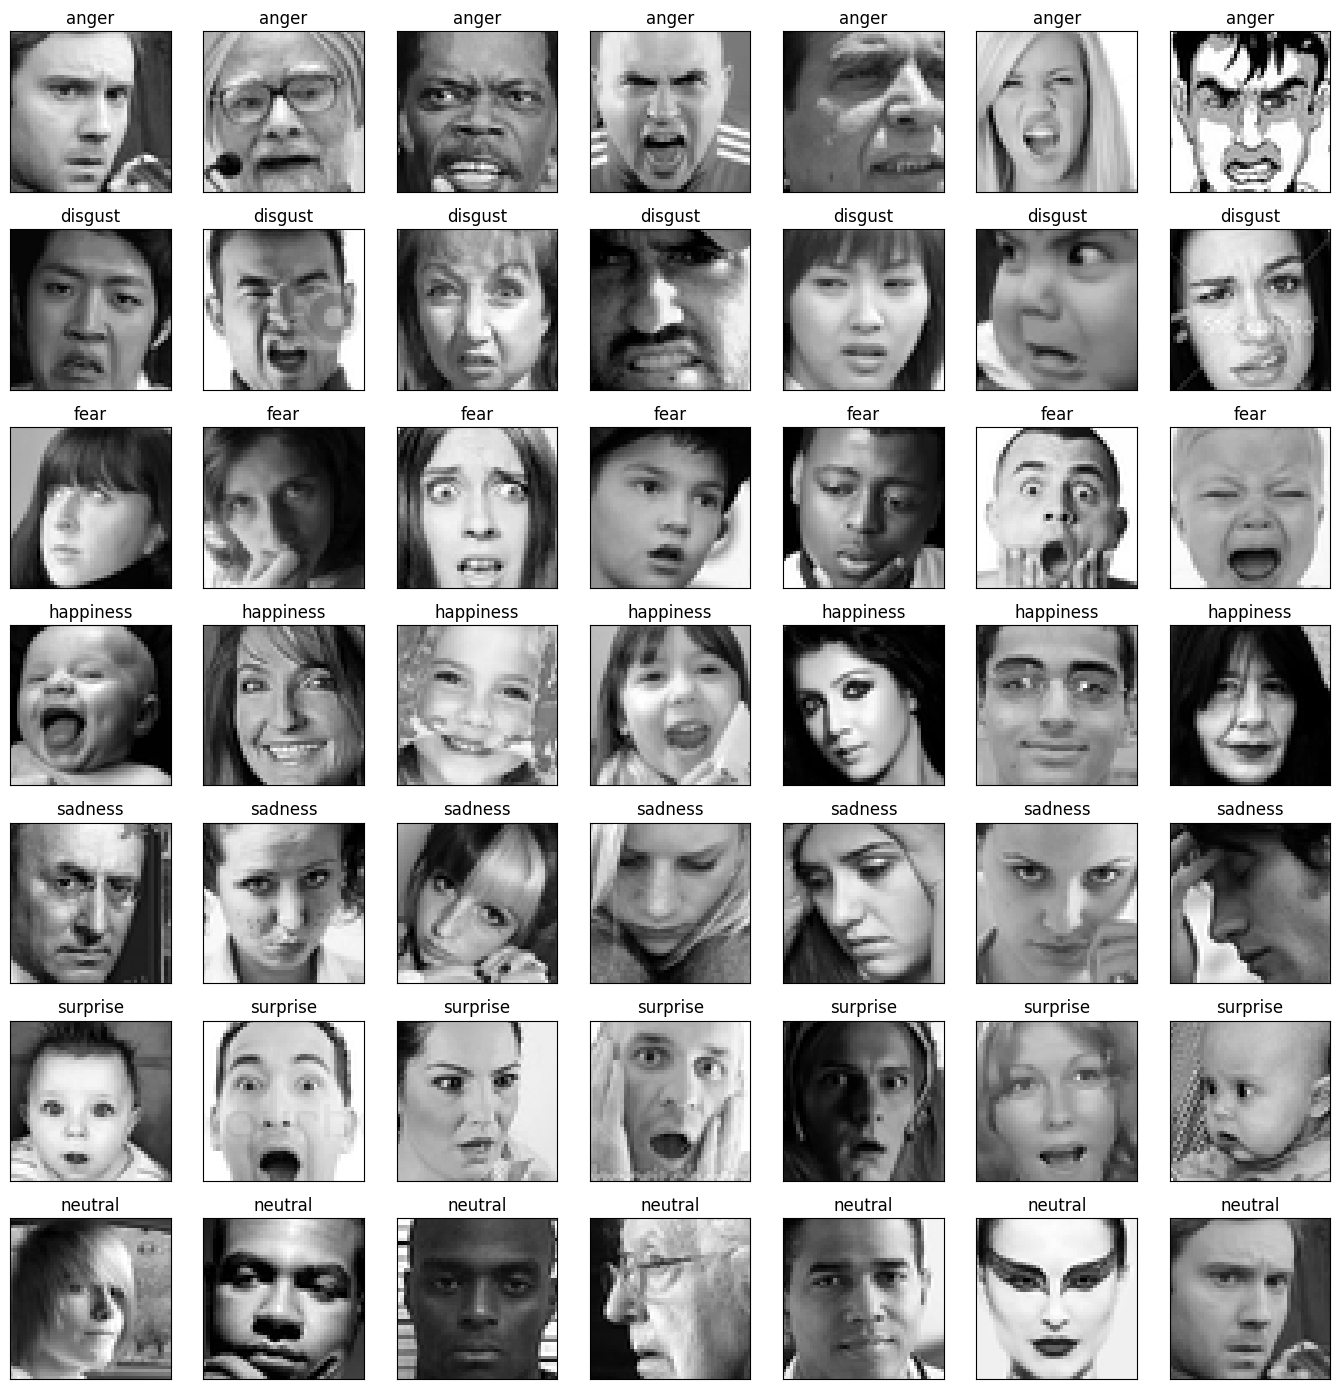

In [ ]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

pyplot.imshow(img_features[0].astype(np.uint8));

In [ ]:
df.emotion.unique()[0]

0

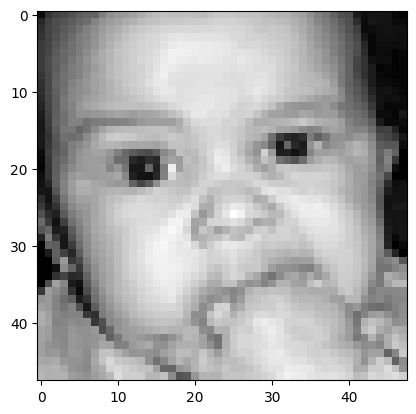

In [ ]:
label_c = df.emotion.unique()[0]
px = df[df.emotion==label_c].pixels.iloc[k]
px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

pyplot.imshow(px, cmap = 'gray')

In [ ]:
#Codificando algumas camadas
le = LabelEncoder()

img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [ ]:
#Separando Dados
X_train, X_valid, y_train, y_valid = train_test_split(img_features,
                                                      img_labels,
                                                      shuffle = True,
                                                      stratify = img_labels,
                                                      test_size = 0.1,
                                                      random_state = 42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 3), (3589, 48, 48, 3), (32298, 7), (3589, 7))

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

NameError: ignored

In [ ]:
#Normalizando
X_train = X_train / 255.
X_valid = X_valid / 255.

# 6 - Definindo modelo

## 6.1 - Importando o modelo pre-treinado do VGG19

In [ ]:
vgg = tf.keras.applications.VGG19(weights = 'imagenet',
                                  include_top = False,
                                  input_shape = (48, 48, 3))

vgg.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

In [ ]:
def build_model(bottom_model, classes):
    model = bottom_model.layers[-2].output
    model = GlobalAveragePooling2D()(model)
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)

    return model

head = build_model(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
#Gerador de imagens
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

In [ ]:
# Otimizador do modelo
# batch size of 32 performs the best.
batch_size = 32
epochs = 50
optims = [optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

In [ ]:
num_train_samples = y_train.shape[0]
num_valid_samples = y_valid.shape[0]

print("Number of training samples:", num_train_samples)
print("Number of validation samples:", num_valid_samples)

Number of training samples: 32298
Number of validation samples: 3589


## 6.2- Treinando

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
history = model.fit(train_datagen.flow(X_train,
                                       y_train,
                                       batch_size = batch_size),
                                       validation_data = (X_valid, y_valid),
                                       steps_per_epoch = len(X_train) / batch_size,
                                       epochs = epochs,
                                       callbacks = [es],
                                       use_multiprocessing = True)

Epoch 1/50
 777/1009 [======================>.......] - ETA: 17:56 - loss: 1.1682 - accuracy: 0.5574

In [ ]:
#Salvando Modelo
model_yaml = model.to_json()
with open("model1.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

model.save("model_vgg19_2.h5")

# 7 . Gráficos

In [ ]:
#Carregando o melhor modelo que geramos
!gdown --id 1sk34B8ExyNsh5cDM5bosSnJFgvmGvOss -O model_vgg16_fer_best.h5

model = models.load_model('/content/model_vgg16_fer_best.h5')

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1sk34B8ExyNsh5cDM5bosSnJFgvmGvOss
To: /content/model_vgg16_fer_best.h5
100% 16.1M/16.1M [00:00<00:00, 82.0MB/s]


In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

In [ ]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()



In [ ]:
class_labels = ['Irritado','Feliz','Neutro','Triste','Surpreso']
list(emotion_label_to_text.values())

['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']

# Checando modelo


1/1 [==============================] - 0s 34ms/step

prediction =  [2.2807117e-03 1.8474036e-06 9.6515208e-01 1.3473920e-03 3.1217853e-02]

prediction max =  2

label previsto  =  fear

label certo  =  fear
1/1 [==============================] - 0s 34ms/step

prediction max =  0

Emoção previsto  =  anger

Emoção certo  =  anger
1/1 [==============================] - 0s 22ms/step

prediction max =  0

Emoção previsto  =  anger

Emoção certo  =  fear
1/1 [==============================] - 0s 21ms/step

prediction max =  2

Emoção previsto  =  fear

Emoção certo  =  sadness
1/1 [==============================] - 0s 24ms/step

prediction max =  2

Emoção previsto  =  fear

Emoção certo  =  neutral
1/1 [==============================] - 0s 23ms/step

prediction max =  4

Emoção previsto  =  sadness

Emoção certo  =  happiness
1/1 [==============================] - 0s 22ms/step

prediction max =  4

Emoção previsto  =  sadness

Emoção certo  =  surprise
1/1 [==============================] 

IndexError: ignored

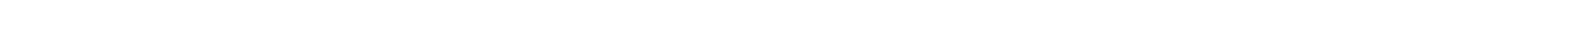

<Figure size 2000x1000 with 0 Axes>

In [ ]:
from tensorflow.keras.utils import img_to_array

#pyplot.imshow(px, cmap = 'gray')
preds = model.predict(px)[0]
print("\nprediction = ",preds)
label=class_labels[preds.argmax()]
print("\nprediction max = ",preds.argmax())
print("\nlabel previsto  = ",label)
print("\nlabel certo  = ",class_labels[label_c])

n_preds = 6                                                 #Numero de imagens


#--------------------------Plotando
plt = pyplot
fig = plt.figure(figsize=(20,0.3))
plt.axis('off')
fig = plt.figure(figsize=(20,10))                                   #Definindo a figura


  label_c = df.emotion.unique()[i]
  px = df[df.emotion==label_c].pixels.iloc[i]

  px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
  px = img_to_array(px)
  px = np.expand_dims(px,axis=0)
  class_labels = list(emotion_label_to_text.values())
  preds = model.predict(px)[0]
  label=class_labels[preds.argmax()]
  print("\nprediction max = ",preds.argmax())
  print("\nEmoção previsto  = ",label)
  '''
  fig.add_subplot(1,n_preds,i+1)                                    #Adicionando um novo subplot
  plt.axis('off')                                                   #Não exibindo os eixos
  #Define os rótulos (flor prevista por nosso modelo, flor correta)
  labels=[f'Flor Prevista: "{preds_full[i][1]}"\nFlor Correta: "{labels_corre[i]}"']
  plt.title(labels[0])
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#plt.subplots_adjust(wspace=None)
plt.show()
'''
print('\n')

1/1 [==============================] - 0s 32ms/step

prediction =  [3.9128810e-01 1.6241748e-07 5.6967300e-01 1.9085798e-02 1.9952940e-02]

prediction max =  2

label previsto  =  Neutro

label certo  =  Feliz
1/1 [==============================] - 0s 33ms/step

prediction max =  2

Emoção previsto  =  fear




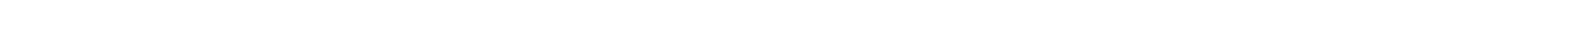

<Figure size 2000x1000 with 0 Axes>

In [ ]:
#tosco mais deve funcionar
from tensorflow.keras.utils import img_to_array

#pyplot.imshow(px, cmap = 'gray')
preds = model.predict(px)[0]
print("\nprediction = ",preds)
label=class_labels[preds.argmax()]
print("\nprediction max = ",preds.argmax())
print("\nlabel previsto  = ",label)
print("\nlabel certo  = ",class_labels[label_c])

n_preds = 6                                                 #Numero de imagens


#--------------------------Plotando
plt = pyplot
fig = plt.figure(figsize=(20,0.3))
plt.axis('off')
fig = plt.figure(figsize=(20,10))                                   #Definindo a figura


label_c = df.emotion.unique()[0]
px = df[df.emotion==label_c].pixels.iloc[i]

px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
px = img_to_array(px)
px = np.expand_dims(px,axis=0)
class_labels = list(emotion_label_to_text.values())
preds = model.predict(px)[0]
label=class_labels[preds.argmax()]
print("\nprediction max = ",preds.argmax())
print("\nEmoção previsto  = ",label)
'''
fig.add_subplot(1,n_preds,i+1)                                    #Adicionando um novo subplot
plt.axis('off')                                                   #Não exibindo os eixos
#Define os rótulos (flor prevista por nosso modelo, flor correta)
labels=[f'Flor Prevista: "{preds_full[i][1]}"\nFlor Correta: "{labels_corre[i]}"']
plt.title(labels[0])
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#plt.subplots_adjust(wspace=None)
plt.show()
'''
print('\n')

In [ ]:
df.emotion.unique()[2]

In [ ]:
yhat_valid = np.argmax(model.predict(X_valid), axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))
print(f'total right validation predictions: {np.sum(np.argmax(y_valid, axis=1) == yhat_valid)}\n\n')


ValueError: ignored